# Imports / Archivos / utils

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# ! pip install geopandas
# ! mkdir pngs
# ! pip install squarify

In [3]:
import datetime
import squarify 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import plotly.graph_objects as go
import geopandas as gpd
import missingno as msno
from matplotlib import cm
%matplotlib inline

In [4]:
id='1VmFflZ2Aoq5sVIssrdDv12XNjUfdHGRv'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('opportunities.csv')
df = pd.read_csv('opportunities.csv',low_memory=False)

In [5]:
def get_year(x):
  date = (x.Opportunity_Created_Date).split("/")
  return int(date[2])

def get_month_str(x):
  month = datetime.date(1900, x.Mes, 1).strftime('%B')
  return month[0:3]

def get_month(x):
  date = (x.Opportunity_Created_Date).split("/")
  return int(date[0])

In [6]:
def drop_none(x):
  if x.Territory == 'None':
    return np.nan
  return x.Territory

In [7]:
#funcion para calcular la conversion a dolar
def conversion_item(x):
    if (x["Total_Amount_Currency"] == "USD"):
        return 1
    elif (x["Total_Amount_Currency"] == x["ASP_Currency"] and float(x["ASP"]) != 0):  
        return x["ASP_(converted)"] / float(x["ASP"])
    else:
        return None

condition_total_amount = (df['Total_Amount_Currency'] != df['ASP_Currency'])\
& (df['Total_Amount_Currency'] != df['ASP_(converted)_Currency'])

# Analisis de los datos


Oportunidades Closed Lost vs Closed Won

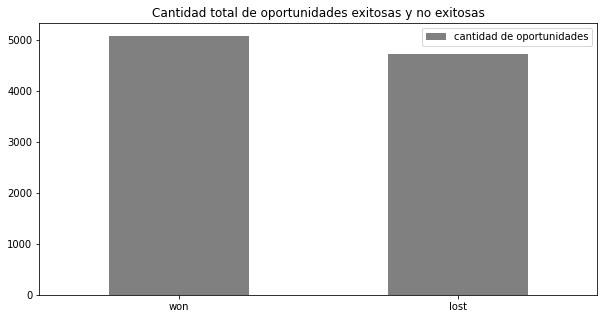

In [8]:
df_op = df.groupby('Opportunity_ID').agg({'Territory': 'first', 'Stage': 'first'}).reset_index()
df_op["Number"] = 1


closed_won = df_op[df_op['Stage'] == 'Closed Won'].sum()['Number']
closed_lost = df_op[df_op['Stage'] == 'Closed Lost'].sum()['Number']

won_vs_lost = pd.DataFrame({'cantidad de oportunidades': [df_op[df_op['Stage'] == 'Closed Won'].sum()['Number']\
                            , df_op[df_op['Stage'] == 'Closed Lost'].sum()['Number']], \
                            'porcentaje':[df_op['Number']]}, \
                           index=['won', 'lost'])
won_vs_lost.plot.bar(rot=0, title='Cantidad total de oportunidades exitosas y no exitosas', color='gray', figsize=(10,5))


## Distribución exito/fracaso por Región

In [9]:
# df_violin_r = df.copy()
# df_violin_r = df_violin_r.groupby("Opportunity ID").agg({"Region": 'first', \
#                                                          'Stage': 'first',})
# df_violin_r = df_violin_r[df_violin_r["Stage"].str.contains("Closed")]
# ax = sns.violinplot(x= "Region", y="ID", hue="Stage",
#                     data=df_violin_r, palette="PiYG", split=True,
#                     scale="count")
# plt.title("Cantidad de productos según su moneda",size=25)
# plt.rcParams["figure.figsize"] = (20,10)
# plt.xlabel("Moneda", fontsize=20)
# plt.ylabel("Cantidad de items", fontsize=20)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.legend(ncol=1,fontsize=20)
# plt.show()

## Columnas nulas

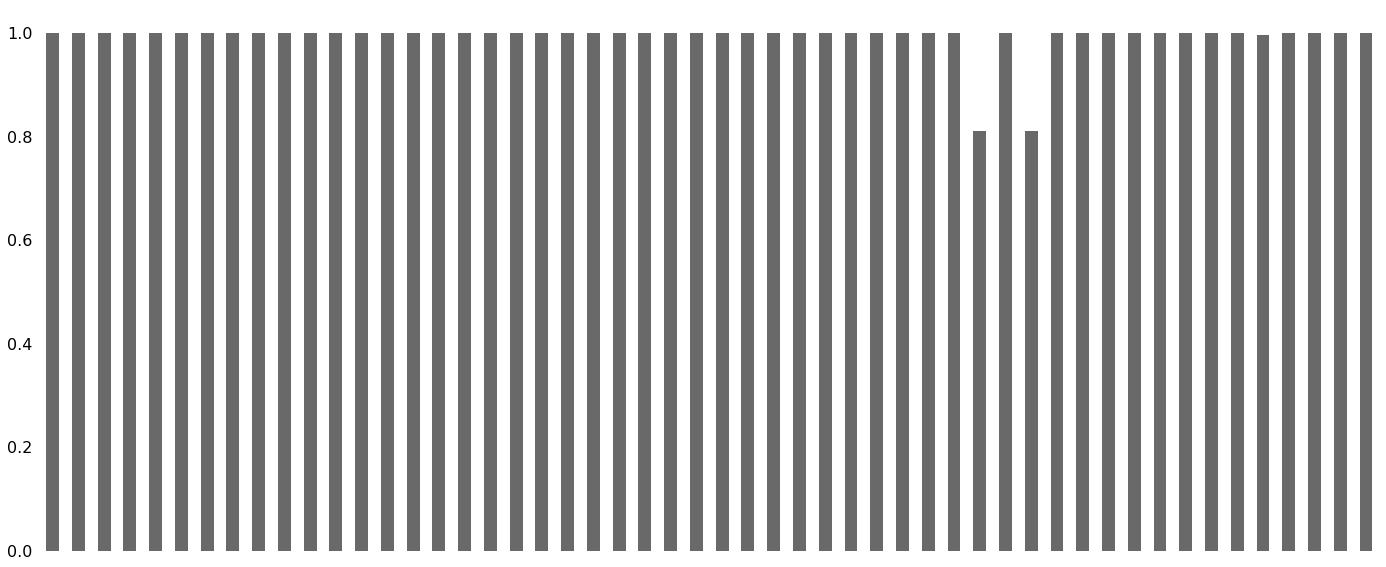

In [10]:
df_na = df.copy()
df_na.replace(to_replace=[None], value=np.nan, inplace=True)


# msno.bar(df_na, figsize=(10,5), fontsize=12);
#msno.matrix(df_na, sort = 'descending')
msno.bar(df)

## Correlacion entre todas las columnas

In [11]:
df_heatmap_filter = df.drop('ID', axis=1)
df_heatmap_filter = df_heatmap_filter.drop('Submitted_for_Approval', axis=1)
df_heatmap_filter = df_heatmap_filter.drop('Opportunity_ID', axis=1)

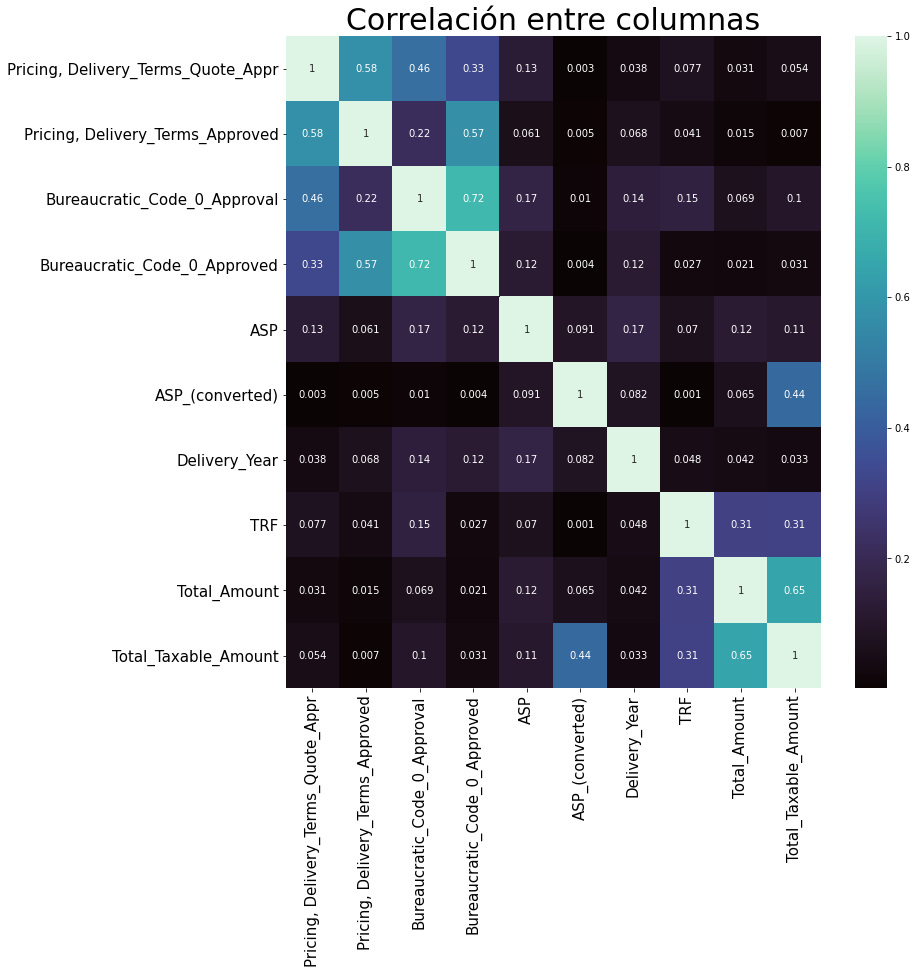

In [12]:
df_heatmap_corr = df_heatmap_filter.corr().abs().round(3)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(df_heatmap_corr, cmap="mako", annot=True);
plt.title("Correlación entre columnas", size=30)
ax.tick_params(labelsize=15)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=0)

# Analisis geográfico 


Top territorios con  mayor cantidad de oportunidades

Text(0.5, 1.0, 'Top 3 territorios con mas oportunidades\n')

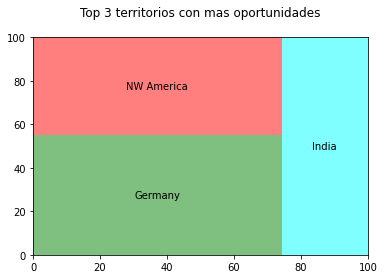

In [13]:
df_op = df.groupby('Opportunity_ID').agg({'Territory': 'first'}).reset_index()
territories = df_op['Territory'].value_counts()
territories = territories.drop('None')
data = territories.head(3)

visu = squarify.plot(data, label=data.index, alpha=.5, color=['green','red','cyan'])
visu.set_title('Top 3 territorios con mas oportunidades\n')

Como Germany y NW America predominan, mismo grafico sin esas localidades

Top territorios con mas oportunidades sin NW America y Germany

Text(0.5, 1.0, 'Top territorios con mas oportunidades sin NW America y Germany\n')

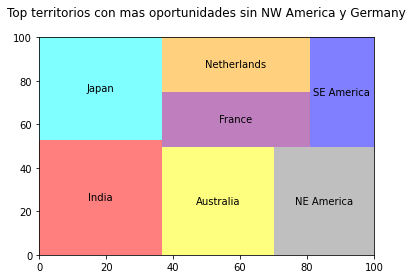

In [14]:
countries = df_op['Territory'].value_counts()
countries = countries.drop('None')
countries = countries.drop('NW America')
countries = countries.drop('Germany')
data = countries.head(7)

visu = squarify.plot(data, label=data.index, alpha=.5, color=['red','cyan','yellow','grey','purple','orange','blue'])
visu.set_title('Top territorios con mas oportunidades sin NW America y Germany\n')

In [15]:
df_stage_geo = df.loc[df["Stage"].str.contains("Closed"),["Opportunity_ID","Stage","Territory","Region"]]
df_stage_geo_terr =  df_stage_geo.copy()
df_stage_geo_terr["Territory"] = df_stage_geo_terr.apply(drop_none, axis=1)
df_stage_geo_terr = df_stage_geo_terr.dropna()
df_stage_geo_terr = df_stage_geo_terr.groupby('Opportunity_ID').agg({"Stage":"first","Territory":"first","Region":"first"}).reset_index()
df_stage_geo_reg = df_stage_geo.groupby('Opportunity_ID').agg({"Stage":"first","Region":"first"}).reset_index()
df_stage_geo_reg.head()

,Opportunity_ID,Stage,Region
0,0,Closed Lost,EMEA
1,1,Closed Won,EMEA
2,2,Closed Won,Americas
3,3,Closed Lost,Americas
4,4,Closed Lost,Americas


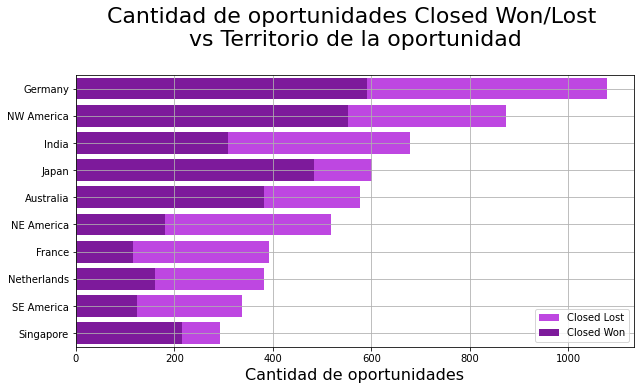

In [16]:
fig,ax = plt.subplots(figsize=(10,5))

g = sns.countplot(data=df_stage_geo_terr,y='Territory',order=df_stage_geo_terr['Territory'].value_counts().head(10).index,color='#CC2EFA')
g = sns.countplot(data=df_stage_geo_terr.loc[df_stage_geo_terr["Stage"]== "Closed Won"],y='Territory',order=df_stage_geo_terr['Territory'].value_counts().head(10).index,color='#8904B1')
plt.legend(['Closed Lost','Closed Won'])
g.set_xlabel('Cantidad de oportunidades',size=16)
g.set_ylabel('')
g.grid()
g.set_title('Cantidad de oportunidades Closed Won/Lost \n vs Territorio de la oportunidad \n',size=22)
g

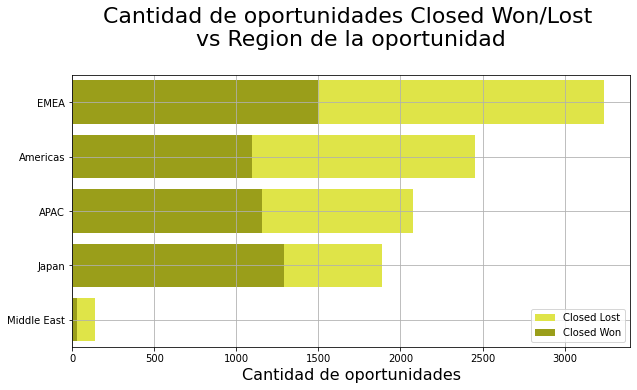

In [17]:
fig,ax = plt.subplots(figsize=(10,5))

g = sns.countplot(data=df_stage_geo_reg,y='Region',order=df_stage_geo_reg['Region'].value_counts().index,color='#F7FE2E')
g = sns.countplot(data=df_stage_geo_reg.loc[df_stage_geo_reg["Stage"]== "Closed Won"],y='Region',order=df_stage_geo_reg['Region'].value_counts().index,color='#AEB404')
plt.legend(['Closed Lost','Closed Won'])
g.set_xlabel('Cantidad de oportunidades',size=16)
g.set_ylabel('')
g.grid()
g.set_title('Cantidad de oportunidades Closed Won/Lost \n vs Region de la oportunidad \n',size=22)
g

Top 10 localidades con mayor cantidad de oportunidades Closed Won


---



In [18]:
df_closed_won = df[df['Stage'] == 'Closed Won']
df_closed_won["Territory"] = df_closed_won.apply(drop_none, axis=1)
df_closed_won.dropna(inplace=True)
df_closed_won = df_closed_won.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_closed_won = df_closed_won.rename(columns={"Stage": "number_of_closed_wons"})
df_closed_won = df_closed_won.sort_values(by='number_of_closed_wons', ascending=False).head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Territorio')

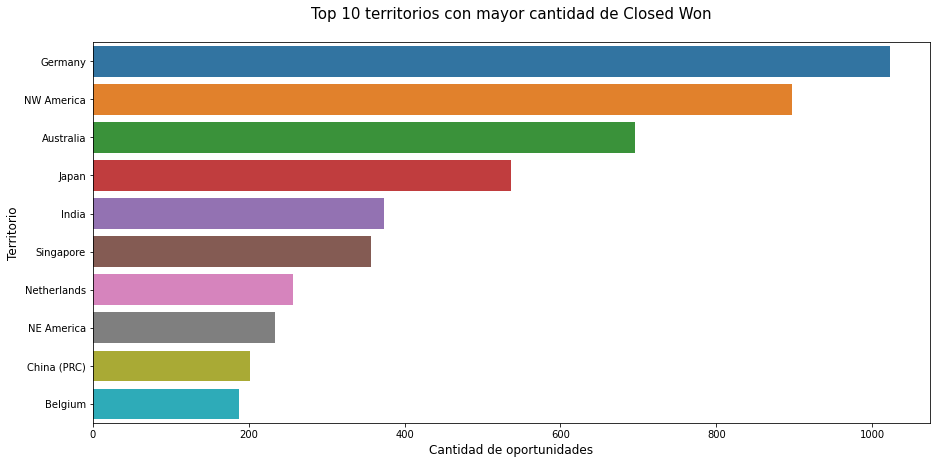

In [19]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_closed_won['number_of_closed_wons'], \
                y=df_closed_won.Territory, orient='h',ax = ax,)
g.set_title("Top 10 territorios con mayor cantidad de Closed Won\n", fontsize=15)
g.set_xlabel("Cantidad de oportunidades", fontsize=12)
g.set_ylabel("Territorio", fontsize=12)

Top 10 localidades con mayor cantidad de oportunidades Closed Lost

In [20]:
df_closed_lost = df[df['Stage'] == 'Closed Lost']
df_closed_lost["Territory"] = df_closed_lost.apply(drop_none, axis=1)
df_closed_lost.dropna(inplace=True)
df_closed_lost = df_closed_lost.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_closed_lost = df_closed_lost.rename(columns={"Stage": "number_of_closed_lost"})
df_closed_lost = df_closed_lost.sort_values(by='number_of_closed_lost', ascending=False).head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Territorio')

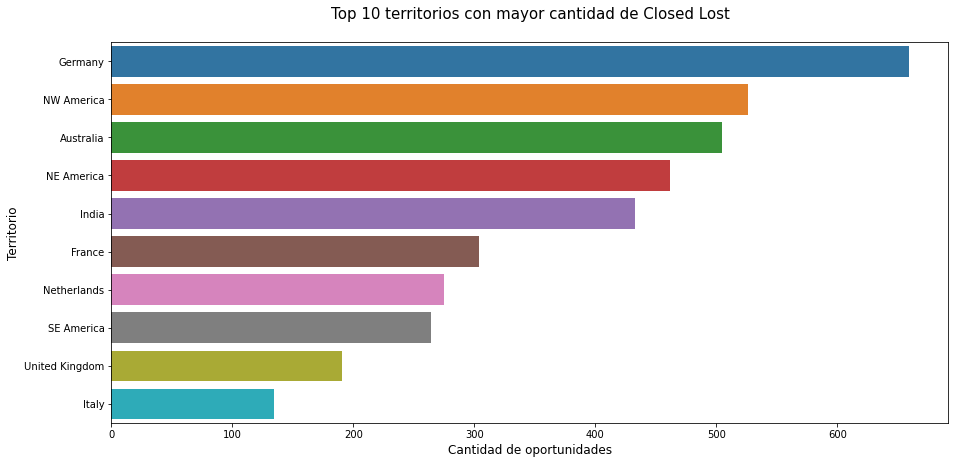

In [21]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_closed_lost['number_of_closed_lost'], \
                y=df_closed_lost.Territory, orient='h',ax = ax,)
g.set_title("Top 10 territorios con mayor cantidad de Closed Lost\n", fontsize=15)
g.set_xlabel("Cantidad de oportunidades", fontsize=12)
g.set_ylabel("Territorio", fontsize=12)

Top localidades con mayor cantidad de oportunidades Negotiation 


In [22]:
df_negotiation = df[df['Stage'] == 'Negotiation']
df_negotiation["Territory"] = df_negotiation.apply(drop_none, axis=1)
df_negotiation.dropna(inplace=True)
df_negotiation = df_negotiation.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_negotiation = df_negotiation.rename(columns={"Stage": "number_of_negotiation"})
df_negotiation = df_negotiation.sort_values(by='number_of_negotiation', ascending=False).head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Territorio')

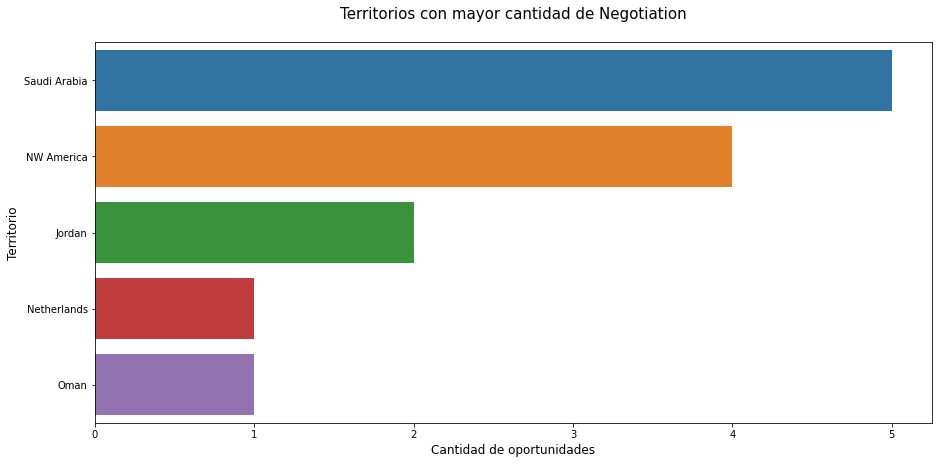

In [23]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_negotiation['number_of_negotiation'], \
                y=df_negotiation.Territory, orient='h',ax = ax,)
g.set_title("Territorios con mayor cantidad de Negotiation\n", fontsize=15)
g.set_xlabel("Cantidad de oportunidades", fontsize=12)
g.set_ylabel("Territorio", fontsize=12)

Top 10 localidades con mayor cantidad de oportunidades Proposal

In [24]:
df_proposal = df[df['Stage'] == 'Proposal']
df_proposal["Territory"] = df_proposal.apply(drop_none, axis=1)
df_proposal.dropna(inplace=True)
df_proposal = df_proposal.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_proposal = df_proposal.rename(columns={"Stage": "number_of_proposal"})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Territorio')

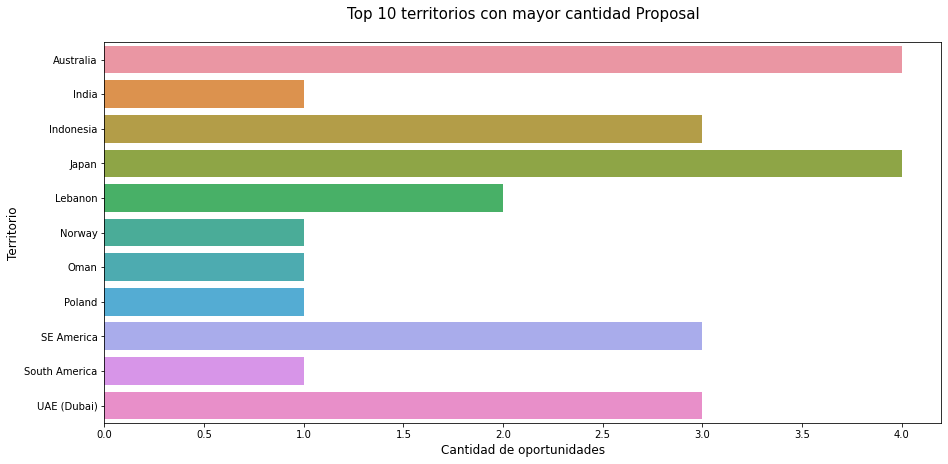

In [25]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_proposal['number_of_proposal'], \
                y=df_proposal.Territory, orient='h',ax = ax,)
g.set_title("Top 10 territorios con mayor cantidad Proposal\n", fontsize=15)
g.set_xlabel("Cantidad de oportunidades", fontsize=12)
g.set_ylabel("Territorio", fontsize=12)

Localidades con mayor cantidad de oportunidades Qualification


In [26]:
df_qualification = df[df['Stage'] == 'Qualification']
df_qualification["Territory"] = df_qualification.apply(drop_none, axis=1)
df_qualification.dropna(inplace=True)
df_qualification = df_qualification.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_qualification = df_qualification.rename(columns={"Stage": "number_of_qualification"})
df_qualification = df_qualification.sort_values(by='number_of_qualification', ascending=False).head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Territorio')

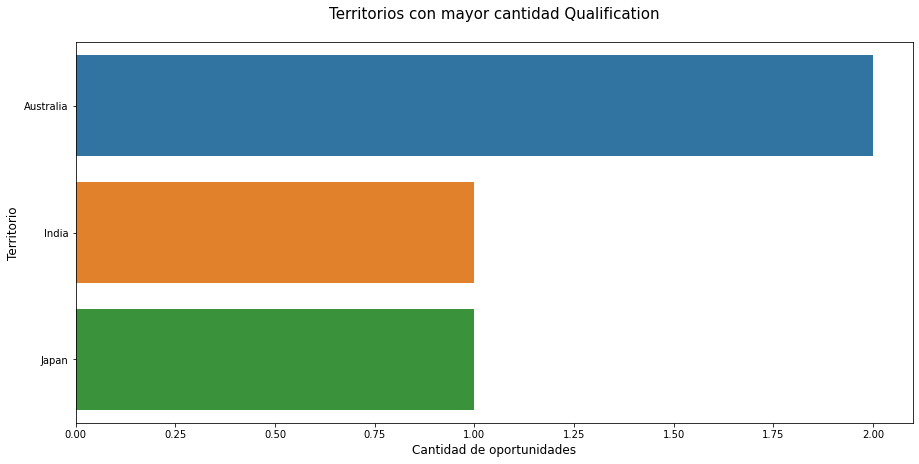

In [27]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_qualification['number_of_qualification'], \
                y=df_qualification.Territory, orient='h',ax = ax,)
g.set_title("Territorios con mayor cantidad Qualification\n", fontsize=15)
g.set_xlabel("Cantidad de oportunidades", fontsize=12)
g.set_ylabel("Territorio", fontsize=12)

## Mapas


In [28]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [29]:
#agrego singapore que no esta en el df world
singapore = gpd.read_file('Maps/Singapore_AL2-AL2.shp')
singapore = singapore.loc[:,["name","country","geometry"]]
singapore.columns = ["name","iso_a3","geometry"]
singapore["continent"] = "Asia"
# world[world["name"].str.contains("R")]

In [30]:
#normalizar datos para permitir el merge con world
df_geo = df.loc[:,["Opportunity_Name","Billing_Country","Territory","Region"]]
df_geo['Billing_Country'] = df_geo['Billing_Country'].fillna(df['Territory'])
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("United States", "United States of America")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Korea, Republic of", "South Korea")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Korea, Democratic People's Republic of", "North Korea")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Reunion", "France")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Macedonia, the former Yugoslav Republic of", "Macedonia")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Bosnia and Herzegovina", "Bosnia and Herz.")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Dominican Republic", "Dominican Rep.")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Viet Nam", "Vietnam")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Czech Republic", "Czechia")
df_geo = df_geo.groupby("Billing_Country").agg({"Opportunity_Name":"count"})
df_geo = df_geo.rename(columns={"Opportunity_Name":"count"})

In [31]:
dfmerge = world.merge(how="left",right=df_geo,right_on="Billing_Country",left_on="name")
dfmerge['count_log'] = np.log(dfmerge['count'])
dfmerge["count"] = dfmerge["count"].fillna(0)
dfmerge["count_log"] = dfmerge["count_log"].fillna(0)

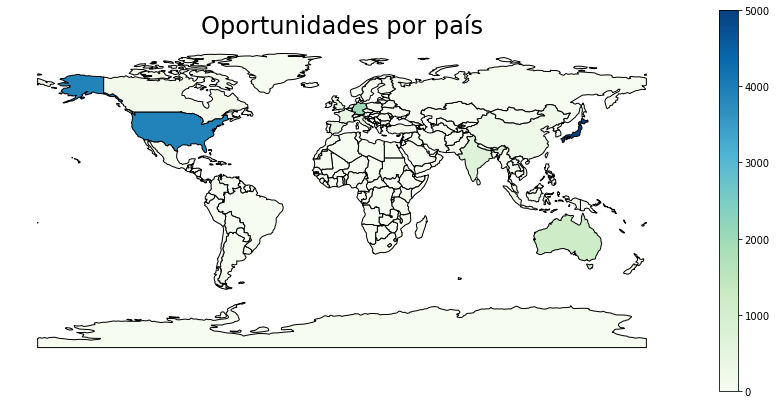

In [32]:
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.axis('off')
plt.title('Oportunidades por país',size=24)
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=0, vmax=5000))
cbar = fig.colorbar(sm)
dfmerge.plot(column='count', cmap='GnBu', ax=ax, edgecolor='black')

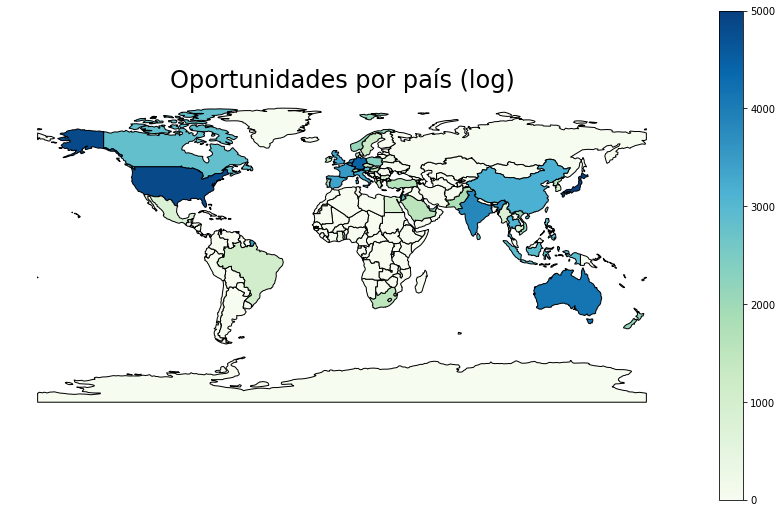

In [33]:
fig, ax = plt.subplots(1, figsize=(15, 9))
ax.axis('off')
plt.title('Oportunidades por país (log)',size=24)
cbar = fig.colorbar(sm)
dfmerge.plot(column='count_log',cmap='GnBu',ax=ax, edgecolor='black')

# Tipo, estado y cantidad de items de las oportunidades

In [34]:
df_copy = df.copy()
df_stage = df_copy.groupby('Opportunity_Name').agg({'Stage': 'last'}).reset_index()
df_stage['Stage'] = df_stage['Stage'].replace("Qualification", "Other")
df_stage['Stage'] = df_stage['Stage'].replace("Negotiation", "Other")
df_stage['Stage'] = df_stage['Stage'].replace("Proposal", "Other")

In [35]:
df_stage_complete = df_copy.groupby('Opportunity_Name').agg({'Stage': 'last'}).reset_index()
df_stage_complete = df_stage_complete['Stage'].value_counts().to_frame().reset_index()
df_stage_complete["Total"] = df_stage_complete["Stage"].sum()
df_stage_complete["Count/Total"] = df_stage_complete["Stage"] / df_stage_complete["Total"]
df_stage_complete["Percentage"] = df_stage_complete["Count/Total"] * 100
df_stage_complete.columns = ["Stage","Count","Total","Count/Total","Percentage"]

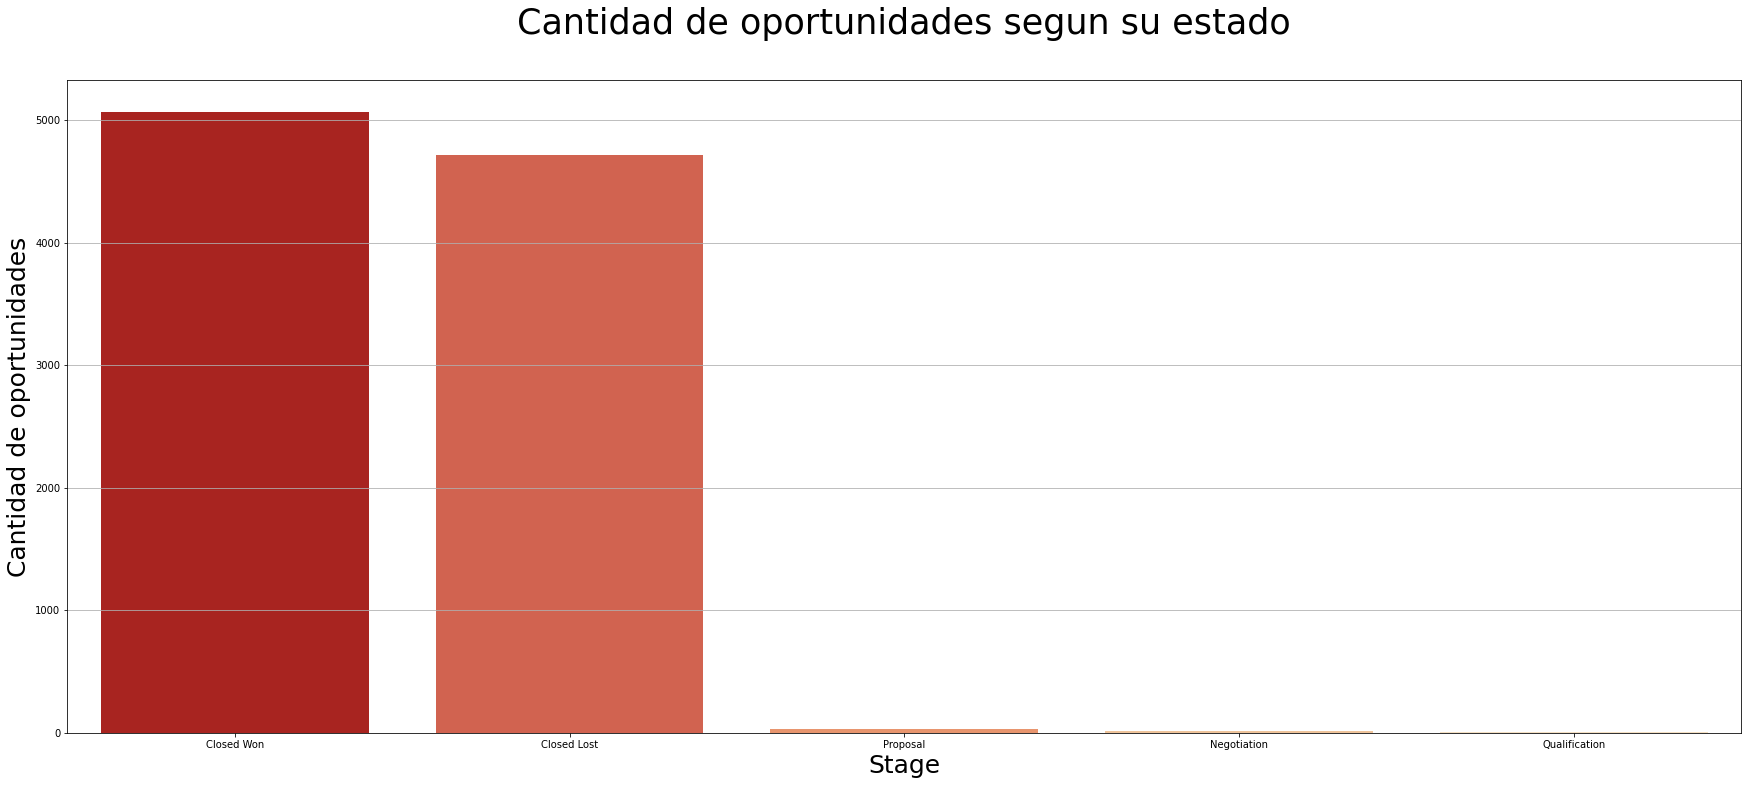

In [36]:
fig,ax=plt.subplots(figsize=(30,12))
plt.grid(True)
g = sns.barplot(ax=ax,data=df_stage_complete,x='Stage',y='Count',palette='OrRd_r',alpha=1)
g.set_title('Cantidad de oportunidades segun su estado\n',size=35)
g.set_xlabel('Stage',size=25)
g.set_ylabel('Cantidad de oportunidades',size=25)
plt.savefig("pngs/Oportunidades-estado.png")

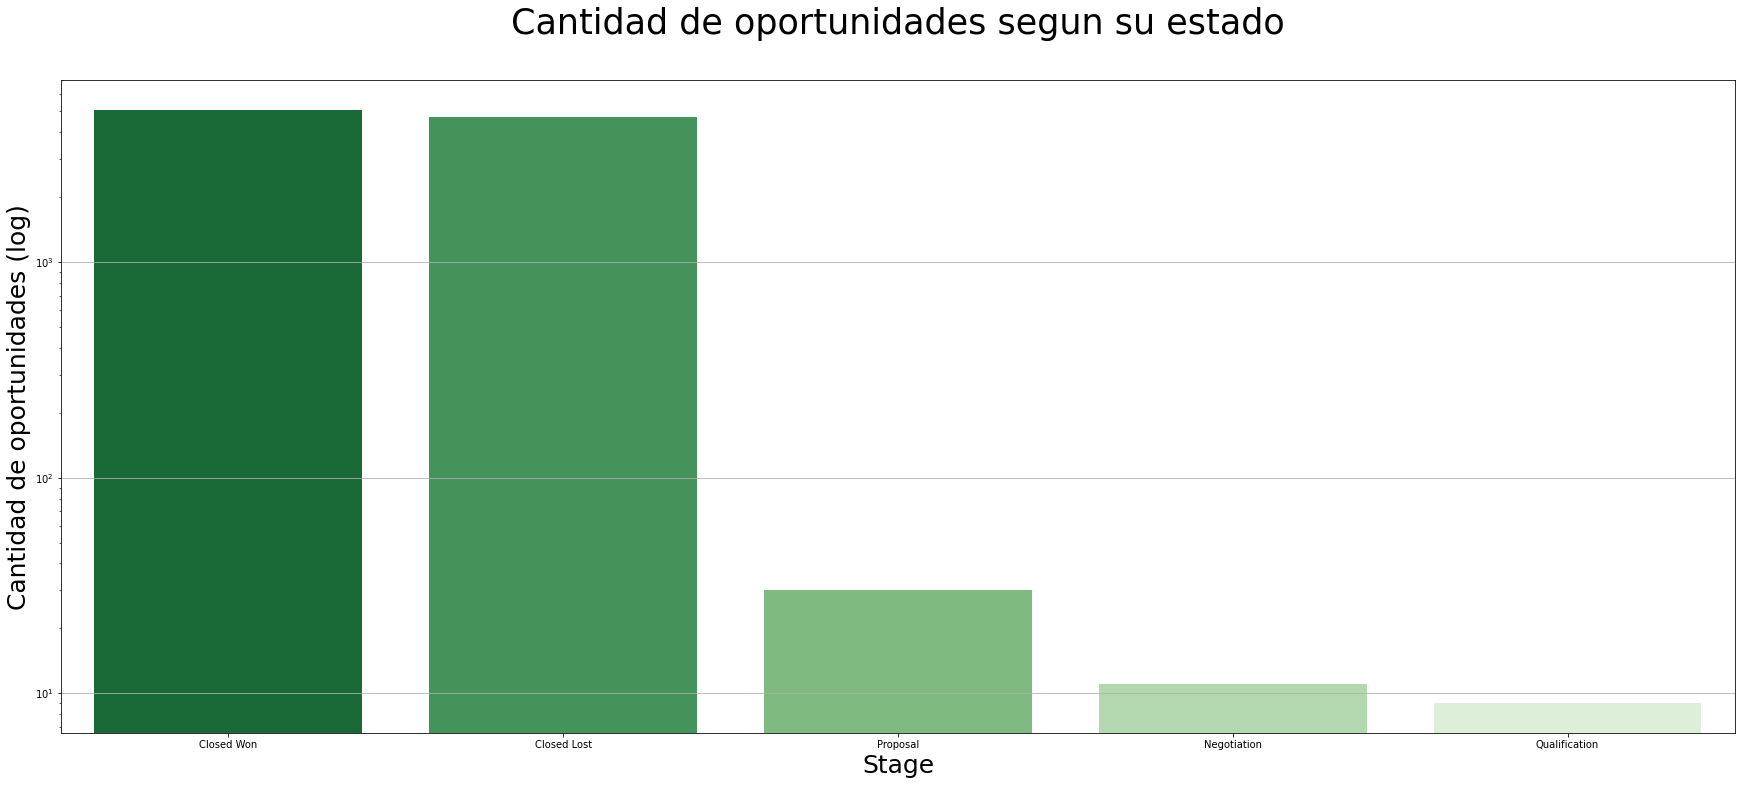

In [37]:
fig,ax=plt.subplots(figsize=(30,12))
plt.grid(True)
plt.yscale('log')
g = sns.barplot(ax=ax,data=df_stage_complete,x='Stage',y='Count',palette='Greens_r',alpha=1)
g.set_title('Cantidad de oportunidades segun su estado\n',size=35)
g.set_xlabel('Stage',size=25)
g.set_ylabel('Cantidad de oportunidades (log)',size=25)
plt.savefig("pngs/Oportunidades-estado-log.png")

In [38]:
df_stage_count = df_stage['Stage'].value_counts().to_frame().reset_index()
df_stage_count["Total"] = df_stage_count["Stage"].sum()
df_stage_count["Count/Total"] = df_stage_count["Stage"] / df_stage_count["Total"]
df_stage_count["Percentage"] = df_stage_count["Count/Total"] * 100
df_stage_count.columns = ["Stage","Count","Total","Count/Total","Percentage"]

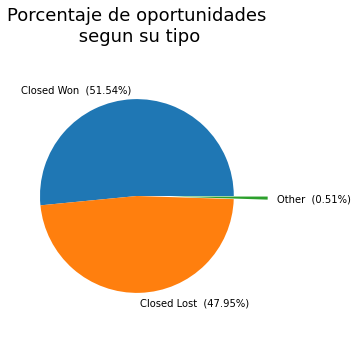

In [39]:
df_stage_count = df_stage_count.round(2)
fig1,ax1 = plt.subplots(figsize=(5,5))

labels=df_stage_count['Stage']+"  (" + (df_stage_count['Percentage']).astype(str) + "%)"

explode = (0, 0, 0.35)
colors = [] #podemos cambiar los colores
ax1.axis('equal')
ax1.pie(df_stage_count['Percentage'],labels=labels,explode=explode)
plt.title('Porcentaje de oportunidades\n segun su tipo',size=18)
plt.tight_layout()
plt.savefig("pngs/Oportunidades-estado-porcentaje.png")
plt.show()

In [40]:
df_scatter = df.copy()
df_scatter = df_scatter.groupby("Opportunity_Name").agg({'Opportunity_ID':'count', 'Stage': 'first'}).reset_index()
df_scatter = df_scatter.rename(columns={"Opportunity_ID": "item_count"})
df_scatter = df_scatter.groupby(["item_count", "Stage"]).agg({"Opportunity_Name":'count'}).unstack().fillna(0).reset_index()
df_scatter.columns = ["item_count", "Closed Lost", "Closed Won", "Negotiation", "Proposal", "Qualification"]

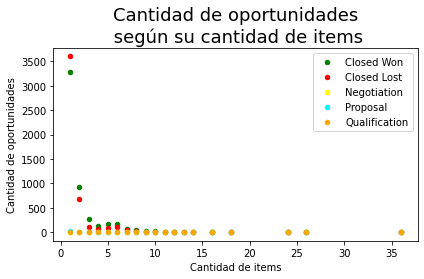

In [41]:
ax = df_scatter.plot(kind='scatter', x='item_count', y='Closed Won',color='Green', \
                               label='Closed Won')

graf = df_scatter.plot(kind='scatter', x='item_count', y='Closed Lost',
         color='Red', label='Closed Lost', ax=ax)

graf = df_scatter.plot(kind='scatter', x='item_count', y='Negotiation',
         color='Yellow', label='Negotiation', ax=ax)

graf = df_scatter.plot(kind='scatter', x='item_count', y='Proposal',
         color='Cyan', label='Proposal', ax=ax)

graf = df_scatter.plot(kind='scatter', x='item_count', y='Qualification',
         color='Orange', label='Qualification', ax=ax)

plt.title('Cantidad de oportunidades\n según su cantidad de items',size=18)
plt.tight_layout()
graf.set_ylabel('Cantidad de oportunidades')
graf.set_xlabel('Cantidad de items')
graf.get_figure().savefig('pngs/Oportunidades-item-1.png')


In [42]:
df_scatter_filter = df_scatter.copy()
df_scatter_filter = df_scatter_filter[df_scatter_filter["item_count"] > 1]

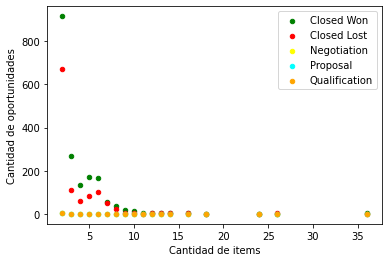

In [43]:
ax = df_scatter_filter.plot(kind='scatter', x='item_count', y='Closed Won',color='Green', \
                               label='Closed Won')

graf = df_scatter_filter.plot(kind='scatter', x='item_count', y='Closed Lost',
         color='Red', label='Closed Lost', ax=ax)

graf = df_scatter_filter.plot(kind='scatter', x='item_count', y='Negotiation',
         color='Yellow', label='Negotiation', ax=ax)

graf = df_scatter_filter.plot(kind='scatter', x='item_count', y='Proposal',
         color='Cyan', label='Proposal', ax=ax)

graf = df_scatter_filter.plot(kind='scatter', x='item_count', y='Qualification',
         color='Orange', label='Qualification', ax=ax)

graf.set_ylabel('Cantidad de oportunidades')
graf.set_xlabel('Cantidad de items')
graf.get_figure().savefig('pngs/Oportunidades-item-2.png')


# Cantidad de Items segun su estado

In [44]:
df_item = df.copy()
df_item = df_item.loc[:,["Stage","ID"]]
df_item = df_item.groupby('Stage').count().reset_index().sort_values("ID",ascending=False)
df_item.columns = ["Stage","Count"]

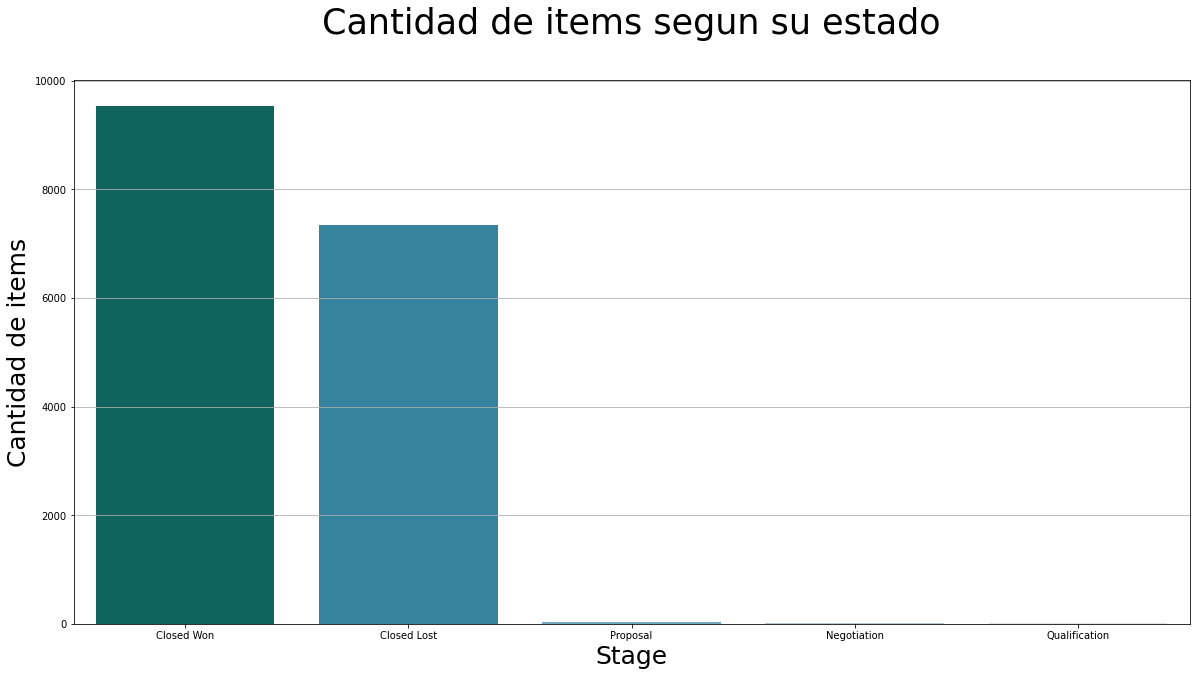

In [45]:
fig,ax=plt.subplots(figsize=(20,10))

plt.grid(True)
g = sns.barplot(ax=ax,data=df_item,x='Stage',y='Count',palette='PuBuGn_r',alpha=1)
g.set_title('Cantidad de items segun su estado\n',size=35)
g.set_xlabel('Stage',size=25)
g.set_ylabel('Cantidad de items',size=25)
plt.savefig("pngs/Items-estado.png")

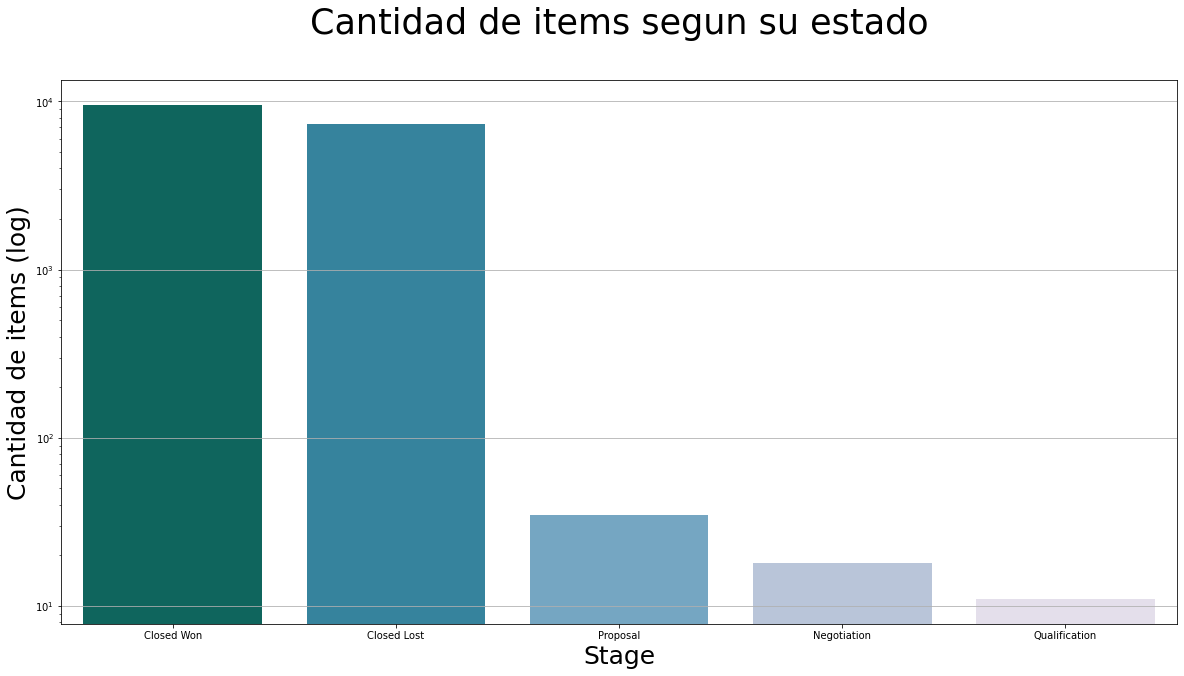

In [46]:
fig,ax=plt.subplots(figsize=(20,10))

plt.grid(True)
g = sns.barplot(ax=ax,data=df_item,x='Stage',y='Count',palette='PuBuGn_r',alpha=1)
g.set_title('Cantidad de items segun su estado\n',size=35)
g.set_xlabel('Stage',size=25)
g.set_ylabel('Cantidad de items (log)',size=25)
plt.yscale("log")
plt.savefig("pngs/Items-estado-log.png")

# Moneda / Montos / Costos

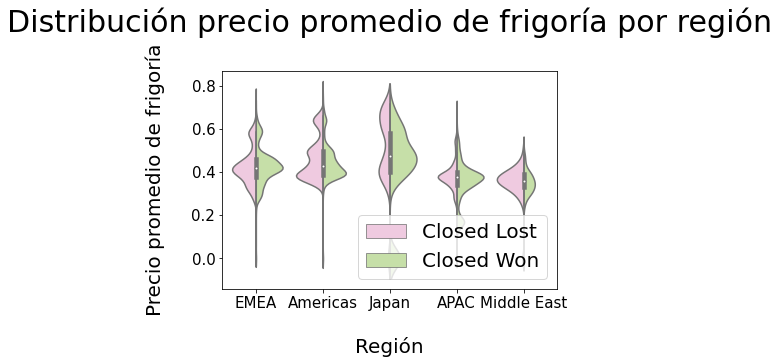

0.78

In [47]:
df_violin = df.copy()
df_violin = df_violin[df_violin["Stage"].str.contains("Closed")]
df_violin["ASP_(converted)"] = pd.to_numeric(df_violin["ASP_(converted)"],errors='coerce')
df_violin = df_violin[df_violin["ASP_(converted)"] < 1]
ax = sns.violinplot(x= "Region", y="ASP_(converted)", hue="Stage",
                    data=df_violin, palette="PiYG", split=True,
                    scale="count")
plt.title("Distribución precio promedio de frigoría por región\n",size=30)
plt.rcParams["figure.figsize"] = (20,10)
plt.xlabel("\nRegión", fontsize=20)
plt.ylabel("Precio promedio de frigoría\n", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(ncol=1,fontsize=20)
plt.show()
df_violin["ASP_(converted)"].max()

In [48]:
#funcion para calcular la conversion a dolar
def conversion(x):
    if (x["Total_Taxable_Amount_Currency"] == "USD"):
        return 1
    elif (x["Total_Taxable_Amount_Currency"] == x["ASP_Currency"] and float(x["ASP"]) != 0):  
        return x["ASP_(converted)"] / float(x["ASP"])
    else:
        return None

In [49]:
#creo condicion donde para filtrar registros donde no tenga manera de convertir a moneda el total taxeable
condition = (df['Total_Taxable_Amount_Currency'] != df['Total_Amount_Currency'])\
& (df['Total_Taxable_Amount_Currency'] != df['ASP_Currency'])\
& (df['Total_Taxable_Amount_Currency'] != df['ASP_(converted)_Currency'])

In [50]:
df_rp = df.loc[condition!= True & df["Stage"].str.contains("Close"),['Opportunity_ID','Total_Amount', 'Stage', 'Total_Amount_Currency','ASP','ASP_Currency','ASP_(converted)','ASP_(converted)_Currency','Total_Taxable_Amount','Total_Taxable_Amount_Currency', 'Pricing, Delivery_Terms_Approved']]

#agrego el valor de conversion a moneda dolar
df_rp["convertion"] = df_rp.apply(conversion, axis=1)
#Convierto el total tax amount a moneda dolar para poder comparar
df_rp["Total Taxable Amount (USD)"] = df_rp["Total_Taxable_Amount"] * df_rp["convertion"]
df_rp = df_rp.groupby("Opportunity_ID").agg({'ASP_Currency': 'count', 'Total Taxable Amount (USD)': 'mean', 'Stage': 'first', 'Pricing, Delivery_Terms_Approved': 'first', 'ASP_(converted)': 'mean'}).reset_index()
df_rp.rename(columns = {'ASP_Currency': 'Cantidad de Items', 'Pricing, Delivery_Terms_Approved': 'Aprobado'}, inplace = True)
df_rp['Frigorias'] = df_rp['Total Taxable Amount (USD)'] / df_rp['ASP_(converted)']
df_rp.rename(columns = {'Total Taxable Amount (USD)': 'Monto total de la oportunidad(USD)'}, inplace = True)

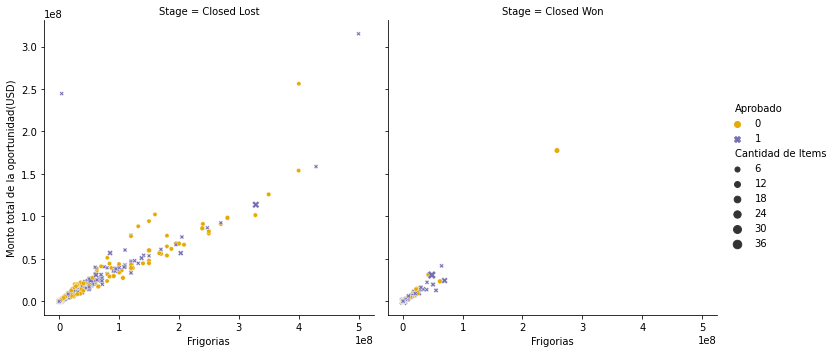

In [51]:
ax = sns.relplot( 
    data=df_rp,
    x="Frigorias", y="Monto total de la oportunidad(USD)", col="Stage",
    hue="Aprobado", style="Aprobado", size="Cantidad de Items", palette = "Dark2_r"
)

Para apreciar mejor el grafico, hacemos un zoom y dejamos fuera algunos datos

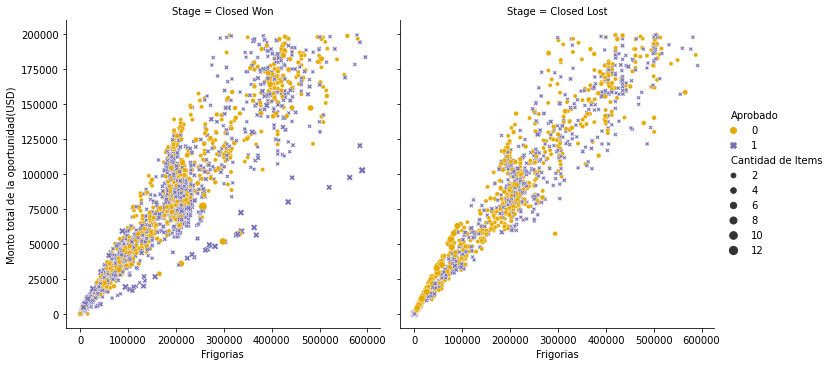

In [52]:
df_rp_filter = df_rp[df_rp['Monto total de la oportunidad(USD)'] < 200000]
df_rp_filter = df_rp_filter[df_rp_filter["Frigorias"] < 600000]

ax = sns.relplot( 
    data=df_rp_filter,
    x="Frigorias", y="Monto total de la oportunidad(USD)", col="Stage",
    hue="Aprobado", style="Aprobado", size="Cantidad de Items", palette = "Dark2_r"
)


In [53]:
df_relp_m = df.copy()

df_relp_m["Mes"] = df_relp_m.apply(get_month, axis=1)
df_relp_m["Año"] = df_relp_m.apply(get_year, axis=1)

df_relp_m = df_relp_m.groupby("Opportunity_ID").agg({'Mes': 'first', 'Año': 'last', 'Stage': 'count'}).reset_index()
df_relp_m.rename(columns={'Stage': 'Cantidad de items de la oportunidad'}, inplace=True)

df_relp_m = df_relp_m.groupby(['Mes', 'Año']).agg({'Opportunity_ID': 'count', 'Cantidad de items de la oportunidad': 'sum'}).reset_index()

df_relp_m["Mes_2"] = df_relp_m.apply(get_month_str, axis=1)

df_relp_m = df_relp_m[df_relp_m["Año"] > 2013]


students = [ (1, 2014, 0 , 0, 'Jan'), 
             (2, 2014, 0 , 0, 'Feb'),
             (4, 2014, 0 , 0, 'Apr'), 
             (11, 2014, 0 , 0, 'Nov'), 
            ]

dfObj = pd.DataFrame(students, columns = ['Mes' , 'Año', 'Opportunity_ID' , 'Cantidad de items de la oportunidad', 'Mes_2'], \
                     index=[57, 58, 59 , 60]) 

df_relp_m = df_relp_m.append(dfObj)
df_relp_m.sort_values(["Año", "Mes"], inplace=True)


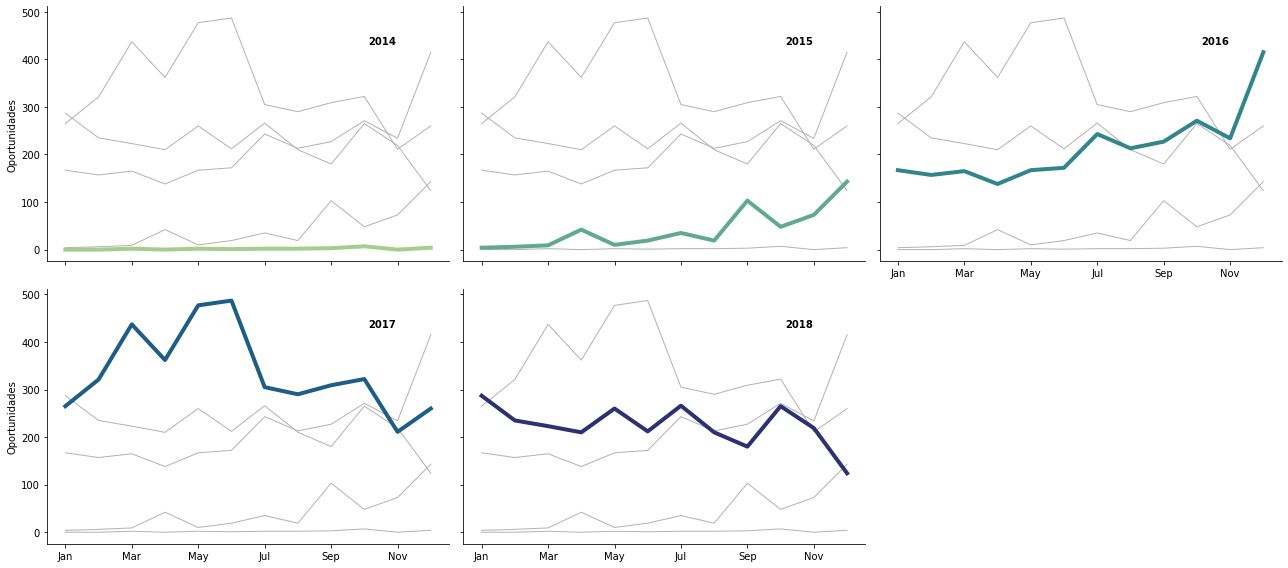

In [54]:
# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_relp_m,
    x="Mes_2", \
    y="Opportunity_ID", \
    col="Año", \
    hue="Año",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=4, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=df_relp_m, x="Mes_2", \
        y="Opportunity_ID", units="Año",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Oportunidades")
g.tight_layout()


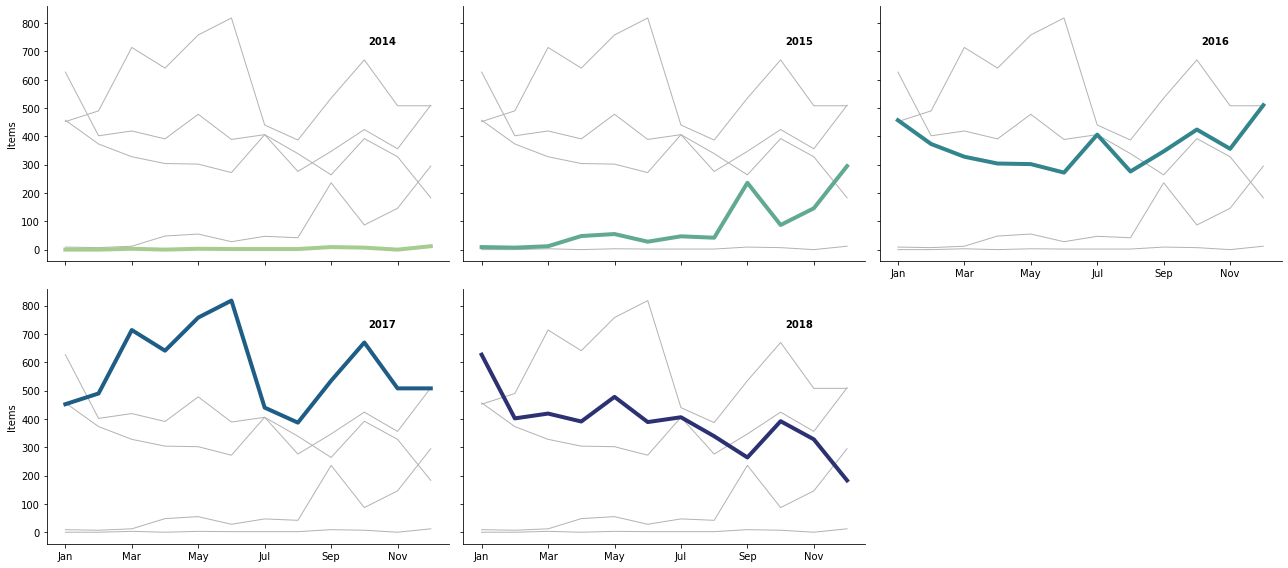

In [55]:
# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_relp_m,
    x="Mes_2", \
    y="Cantidad de items de la oportunidad", \
    col="Año", \
    hue="Año",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=4, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=df_relp_m, x="Mes_2", \
        y="Cantidad de items de la oportunidad", units="Año",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Items")
g.tight_layout()


# Insights

In [56]:
# % de aprobación,
# % de exito,
# # de oportunidades
# monto total promedio
# cantidad promedio de frigorias

def stage2binary(x):
  if x.Stage == "Closed Won":
    return 1
  return 0


df_rc = df.copy()
df_rc = df_rc[df_rc['ASP_(converted)'] > 0]
#agrego el valor de conversion a moneda dolar
df_rc["convertion"] = df_rc.apply(conversion, axis=1)
#Convierto el total tax amount a moneda dolar para poder comparar
df_rc["Total Taxable Amount (USD)"] = df_rc["Total_Taxable_Amount"] * df_rc["convertion"]
df_rc.rename(columns = {'ASP_Currency': 'Cantidad de Items', 'Pricing, Delivery_Terms_Approved': 'Aprobado'}, inplace = True)
df_rc['Frigorias'] = df_rc['Total Taxable Amount (USD)'] / df_rc['ASP_(converted)']
df_rc["stage_binary"] = df_rc.apply(stage2binary, axis=1)
df_rc
df_rc = df_rc.groupby("Opportunity_ID").agg({'stage_binary': 'first', \
                                             'Aprobado': 'first', \
                                             'Total Taxable Amount (USD)': 'mean', \
                                             'Frigorias': 'mean', \
                                             'Region': 'first'}).reset_index()
df_rc = df_rc.groupby("Region").agg({'stage_binary': 'mean', \
                                     'Opportunity_ID': 'count', \
                                     'Aprobado': 'mean', \
                                     'Total Taxable Amount (USD)': 'mean', \
                                     'Frigorias': 'mean'}).reset_index()
df_rc.rename(columns = {
    'stage_binary': 'Porcentaje de exito',
    'Opportunity_ID': 'Cantidad de Oportunidades',
    'Aprobado': 'Porcentaje de aprobacion',
    'Total Taxable Amount (USD)': 'Monto total promedio',
    'Frigorias': 'Promedio de frigorias'
}, inplace=True)
df_rc['Porcentaje de exito'] = df_rc['Porcentaje de exito']*100
df_rc['Porcentaje de aprobacion'] = df_rc['Porcentaje de aprobacion']*100
df_rc['Promedio de frigorias'] = df_rc['Promedio de frigorias'] / df_rc['Promedio de frigorias'].sum() * 100
df_rc['Monto total promedio'] = df_rc['Monto total promedio'] / df_rc['Monto total promedio'].sum() * 100
df_rc['Cantidad de Oportunidades'] = df_rc['Cantidad de Oportunidades'] / df_rc['Cantidad de Oportunidades'].sum() * 100

In [57]:
from math import pi
def make_spider( row, title, color):
 
    # number of variable
    categories=list(df_rc)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(2,2,1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([30,60,90], ["30","60","90"], color="black", size=7)
    plt.ylim(0,90)


    values=df_rc.loc[row].drop('Region').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)


    plt.title(title, size=11, color=color, y=1.1)

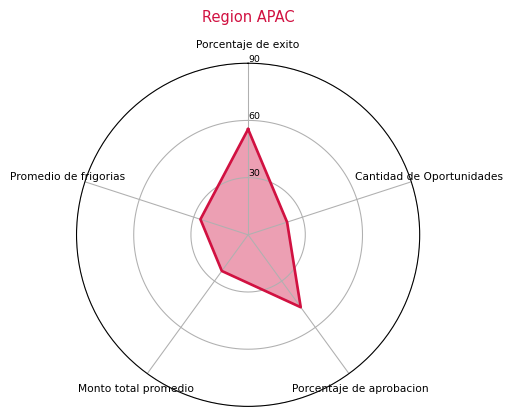

In [58]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=0, title='Region '+df_rc['Region'][0], color='#d11141')

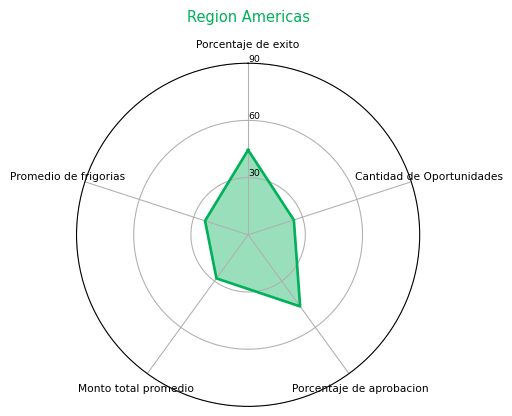

In [59]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=1, title='Region '+df_rc['Region'][1], color='#00b159')

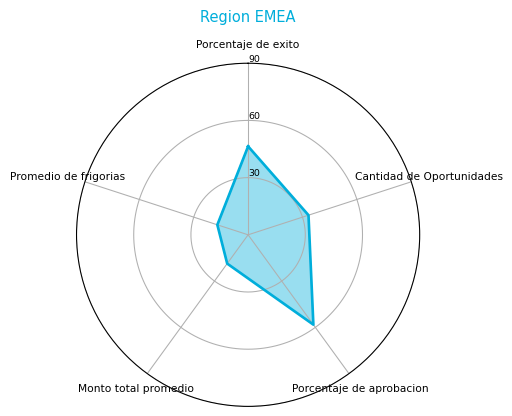

In [60]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=2, title='Region '+df_rc['Region'][2], color='#00aedb')

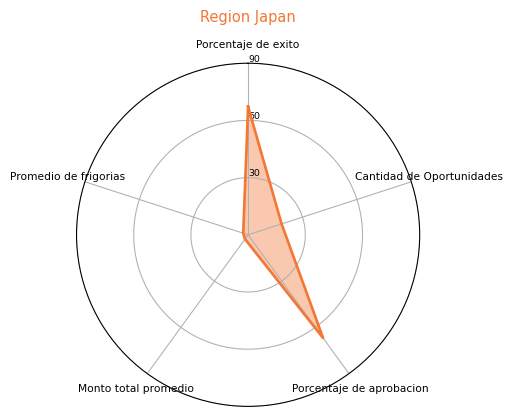

In [61]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=3, title='Region '+df_rc.head(4)['Region'][3], color='#f37735')

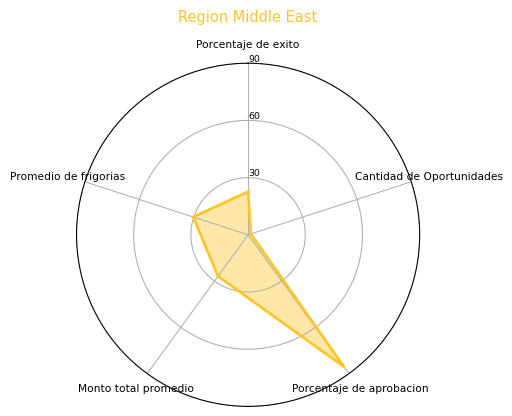

In [62]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=4, title='Region '+df_rc['Region'][4], color='#ffc425')

# Consultar


In [63]:
df_heatmap_filter_stage = df[['Pricing, Delivery_Terms_Quote_Appr', 'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval', \
 'Bureaucratic_Code_0_Approved','Stage']]
df_heatmap_filter_stage = df_heatmap_filter_stage[(df_heatmap_filter_stage['Stage'] == 'Closed Won') | (df_heatmap_filter_stage['Stage'] == 'Closed Lost')]
df_heatmap_filter_stage['Stage'] = df_heatmap_filter_stage['Stage'].replace("Closed Won", "1")
df_heatmap_filter_stage['Stage'] = df_heatmap_filter_stage['Stage'].replace("Closed Lost", "0")
df_heatmap_filter_stage['Stage'] = pd.to_numeric(df_heatmap_filter_stage['Stage'])
df_heatmap_corr_filter_stage = df_heatmap_filter_stage.corr().abs().round(3)

In [64]:
df_heatmap_filter_total_amounts = df[['Total_Taxable_Amount', 'Total_Amount','ASP', 'ASP_(converted)', 'TRF', ]]
df_heatmap_filter_approval = df[['Pricing, Delivery_Terms_Quote_Appr', 'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval', \
 'Bureaucratic_Code_0_Approved']]

In [65]:
df_heatmap_corr_total_amounts = df_heatmap_filter_total_amounts.corr().abs().round(3)
df_heatmap_corr_approval = df_heatmap_filter_approval.corr().abs().round(3)

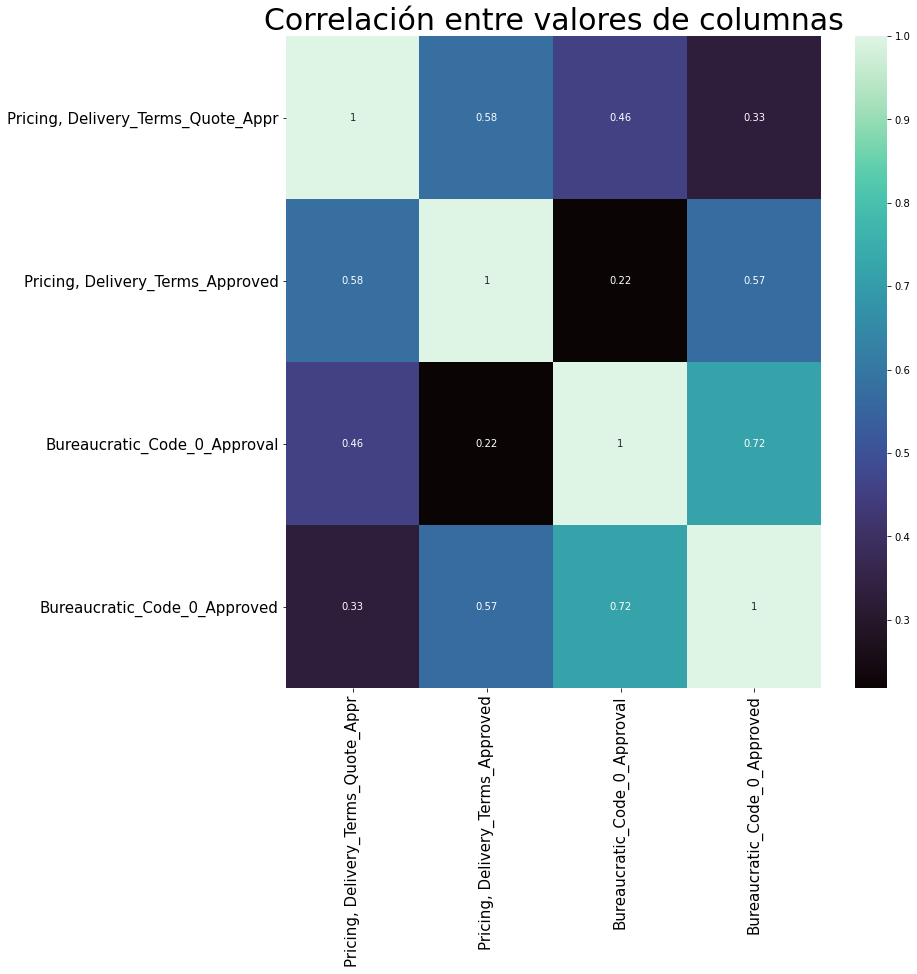

In [66]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(df_heatmap_corr_approval, cmap="mako", annot=True);
plt.title("Correlación entre valores de columnas", size=30)
ax.tick_params(labelsize=15)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=0)

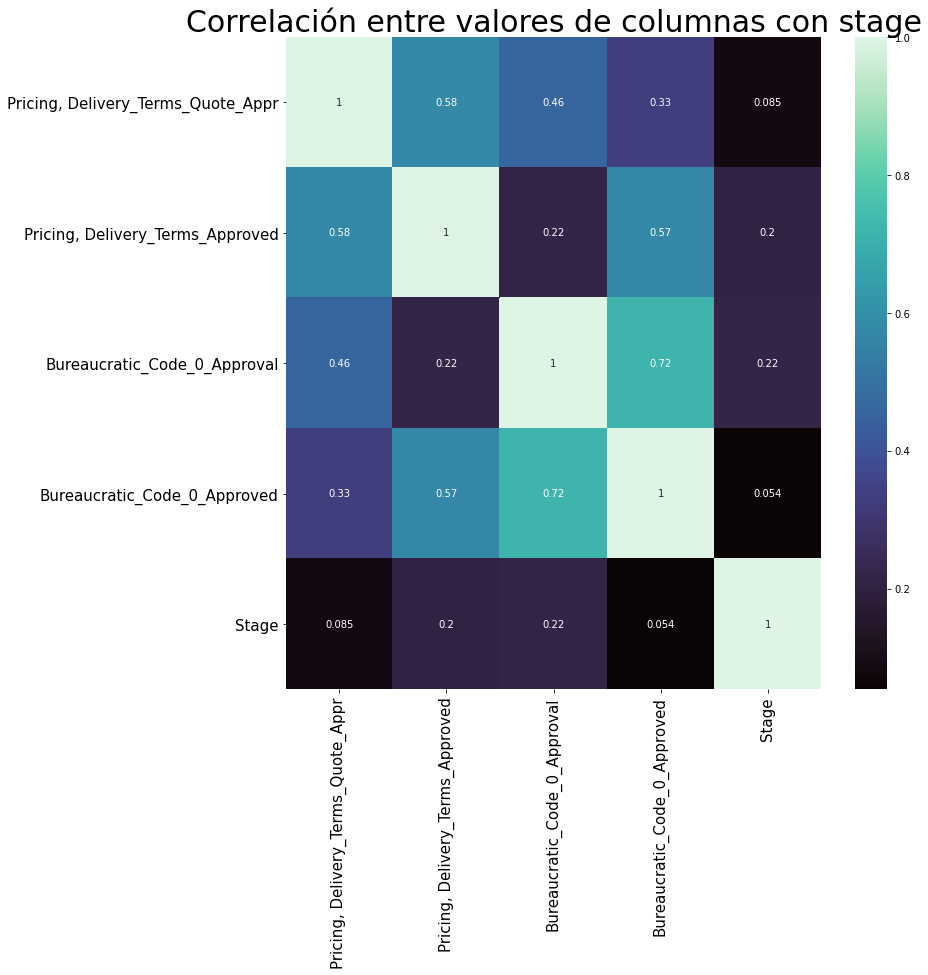

In [67]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(df_heatmap_corr_filter_stage, cmap="mako", annot=True);
plt.title("Correlación entre valores de columnas con stage", size=30)
ax.tick_params(labelsize=15)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=0)

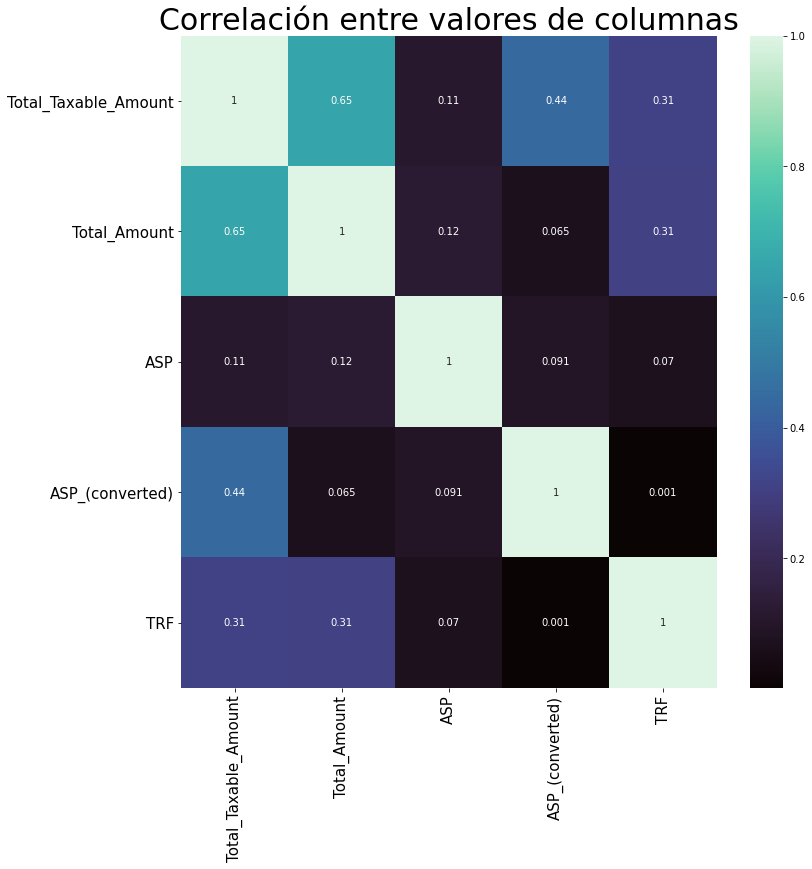

In [68]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(df_heatmap_corr_total_amounts, cmap="mako", annot=True);
plt.title("Correlación entre valores de columnas", size=30)
ax.tick_params(labelsize=15)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=0)